In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.genmod.generalized_linear_model import SET_USE_BIC_LLF
from scipy.stats import nbinom

# Import custom modules and functions
from generate_hnb import generate_hnb
from generate_ZI import generate_ZI
from AIC_BIC import calculate_aic_bic

# Import model classes
from models.HurdlePoisson import ZeroKInflatedPoisson as ZKIHurdle
from models.ZINB import ZINB_EM, predict_mean as ZINB_pred_mean
from models.ZIP import ZIP_EM, predict_mean as ZIP_pred_mean
from models.ZKINB import ZkINB_EM
from models.ZKIP import ZKIP_EM
from models.ZkICMP import ZkICMP


class ModelEvaluator:
    """Class to evaluate and compare different count data models."""
    
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.n_train = X_train.shape[0]
        self.results = {}
    
    def evaluate_model(self, model_name, y_pred, llf, k_params):
        """Calculate evaluation metrics for a model."""
        metrics = {
            'mse': mean_squared_error(self.y_test, y_pred),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred),
            'llf': llf,
            'aic': calculate_aic_bic(self.n_train, llf, k_params)[0],
            'bic': calculate_aic_bic(self.n_train, llf, k_params)[1]
        }
        self.results[model_name] = metrics
        return metrics


def define_model_parameters():
    """Define parameter counts for different models."""
    return {
        'poisson': 2,
        'nb': 3,  # if r known (2)
        'zip': 4,  # 2+2
        'zinb': 5,  # if r known (2+2+1)
        'zkhurdle_poi': 4,  # 2+2
        'zkip': 6,  # 2+2+2
        'zkinb': 7,  # if r known (2+2+2+1)
        'zkicmp': 7  # 2+2+2+1
    }


def fit_models(X_train, X_test, y_train, y_test, k):
    # Configuration
    SET_USE_BIC_LLF(True)
    
    # Get parameter counts
    param_counts = define_model_parameters()
    
    # Initialize evaluator
    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test)
    
    # 1. Poisson Model
    print("Fitting Poisson model...")
    poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    poisson_pred = poisson_model.predict(X_test)
    evaluator.evaluate_model(
        'poisson', poisson_pred, poisson_model.llf, param_counts['poisson']
    )
    
    # 2. Negative Binomial Model
    print("Fitting Negative Binomial model...")
    nb_model = sm.NegativeBinomial(y_train, X_train).fit()
    nb_pred = nb_model.predict(X_test)
    evaluator.evaluate_model(
        'negative_binomial', nb_pred, nb_model.llf, param_counts['nb']
    )
    
    # 3. Zero-K Inflated Poisson Hurdle Model
    print("Fitting Zero-K Inflated Poisson Hurdle model...")
    zkihurdle_model = ZKIHurdle(k=3)
    zkihurdle_res = zkihurdle_model.fit(X_train, y_train)
    zkihurdle_ll = zkihurdle_model.loglikelihood(X_train, y_train)
    zkihurdle_pred = zkihurdle_model.predict_mean(X_test)
    evaluator.evaluate_model(
        'zk_hurdle_poisson', zkihurdle_pred, zkihurdle_ll, param_counts['zkhurdle_poi']
    )
    
    # 4. ZINB Model
    print("Fitting ZINB model...")
    alpha = 1/10
    beta, gamma, zinb_ll = ZINB_EM(y_train.values, X_train.values, X_train.values, alpha)
    zinb_pred = ZINB_pred_mean(X_test.values, X_test.values, beta, gamma)
    evaluator.evaluate_model(
        'zinb', zinb_pred, zinb_ll, param_counts['zinb']
    )
    
    # 5. ZIP Model
    print("Fitting ZIP model...")
    beta, gamma, zip_ll = ZIP_EM(y_train.values, X_train.values, X_train.values)
    zip_pred = ZIP_pred_mean(X_test.values, X_test.values, beta, gamma)
    evaluator.evaluate_model(
        'zip', zip_pred, zip_ll, param_counts['zip']
    )
    
    # 6. ZKINB Model
    print("Fitting ZKINB model...")
    zkinb_model = ZkINB_EM()
    zkinb_res = zkinb_model.fit_em(y_train, X_train.values, X_train.values, k)
    zkinb_pred = zkinb_model.predict(X_test.values, X_test.values)
    evaluator.evaluate_model(
        'zkinb', zkinb_pred, zkinb_res['final_loglik'], param_counts['zkinb']
    )
    
    # 7. ZKIP Model
    print("Fitting ZKIP model...")
    zkip_model = ZKIP_EM(k_inflated=k)
    zkip_res = zkip_model.fit(X_train.values, y_train.values)
    zkip_pred = zkip_model.predict_expected(X_test.values)
    evaluator.evaluate_model(
        'zkip', zkip_pred, zkip_res.final_loglik, param_counts['zkip']
    )
    
    # 8. ZkICMP Model
    print("Fitting ZkICMP model...")
    zkicmp_model = ZkICMP(k=k)
    zkicmp_res = zkicmp_model.fit(X_train.values, y_train.values)
    pred_results = zkicmp_model.predict(X_test.values)
    _, _, zkicmp_pred, _ = pred_results
    evaluator.evaluate_model(
        'zkicmp', zkicmp_pred, -zkicmp_res.final_loglik, param_counts['zkicmp']
    )
    
    # Print results
    print("\n" + "="*80)
    print("MODEL COMPARISON RESULTS")
    print("="*80)
    
    results={}
    for model_name, metrics in evaluator.results.items():
        results[f'{model_name.upper()}_MSE']= metrics['mse']
        results[f'{model_name.upper()}_MAE']= metrics['mae']
        results[f'{model_name.upper()}_R2']= metrics['r2']
        results[f'{model_name.upper()}_LLF']= metrics['llf']
        results[f'{model_name.upper()}_AIC']= metrics['aic']
        results[f'{model_name.upper()}_BIC']= metrics['bic']
    return results

def main():
    k = 3
    n = 300
    
    # Split data indexes
    train_ind, test_ind = train_test_split(
        np.arange(0,n), 
        test_size=0.3, random_state=42
    )

    results=[]
    for beta in np.linspace(-2, 2, 9):
        for gamma in np.linspace(-2, 2, 9):
            for alpha in np.linspace(-2, 2, 9):
                k+=1
                """Generate and prepare the dataset for modeling."""
                # Generate data
                df = generate_ZI(
                    n=n, k=k, beta0=-1, beta1=1, gamma0=-2, gamma1=0.3,
                    alpha0=0.5, alpha1=1, r=10, cov_type="nbinary"
                )
                
                # Prepare features and target
                X = df.loc[:, 'x'].values
                y_target = df.loc[:, 'y'].values
                
                # Add intercept
                X = sm.add_constant(X)
                X = pd.DataFrame(X, columns=['intercept', 'x'])
                y_target = pd.DataFrame(y_target, columns=['y'])
                
                X_train = X.iloc[train_ind, :]
                X_test = X.iloc[test_ind, :]
                y_train = y_target.loc[train_ind, 'y']
                y_test = y_target.loc[test_ind, 'y']
                print(type(y_train))
                # outputs
                p_0 = (y_train==0).mean()
                p_k = (y_train==k).mean()
                p_p = max(1 - p_0 - p_k, 0)
                y_mean = y_train.mean()
                y_std = y_train.std()
                n_unique = len(y_train.value_counts())

                r_hat = y_mean**2 / (y_std**2 - y_mean)
                p0_nb = nbinom.pmf(0, r_hat, r_hat/(r_hat+y_mean))
                pk_nb = nbinom.pmf(k, r_hat, r_hat/(r_hat+ y_mean))

                zero_inflated = p_0>p0_nb
                k_inflated = p_k>pk_nb

                model_results=fit_models(X_train, X_test, y_train, y_test, k)
        
                results.append(
                    {
                        'beta':beta,
                        'gamma':gamma,
                        'alpha': alpha,
                        'p_0':p_0,
                        'p_k':p_k,
                        'p_p':p_p,
                        'y_mean':y_mean,
                        'y_std':y_std,
                        'n_unique':n_unique,
                        'r_hat':r_hat,
                        'p0_nb':p0_nb,
                        'pk_nb':pk_nb,
                        'zero_inflated':zero_inflated,
                        'k_infated':k_inflated,
                    } | model_results
                )    

    return results    

    
if __name__ == "__main__":
    
    results = main()

<class 'pandas.core.series.Series'>
Fitting Poisson model...
Fitting Negative Binomial model...
Optimization terminated successfully.
         Current function value: 1.712625
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Fitting Zero-K Inflated Poisson Hurdle model...
Fitting ZINB model...
Fitting ZIP model...
Fitting ZKINB model...
Fitting ZKIP model...
Fitting ZkICMP model...

MODEL COMPARISON RESULTS
<class 'pandas.core.series.Series'>
Fitting Poisson model...
Fitting Negative Binomial model...
Optimization terminated successfully.
         Current function value: 1.658644
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Fitting Zero-K Inflated Poisson Hurdle model...
Fitting ZINB model...
Fitting ZIP model...
Fitting ZKINB model...
Fitting ZKIP model...
Fitting ZkICMP model...

MODEL COMPARISON RESULTS
<class 'pandas.core.series.Series'>
Fitting Poisson model...
Fitting Negative Binomial model...


In [9]:
pd.DataFrame(results).to_csv('results_test.csv')

In [23]:
# Split data indexes
import numpy as np
n=300
train_ind, test_ind = train_test_split(
        np.arange(0,n), 
        test_size=0.3, random_state=42
)

train_ind

array([194, 101,  68, 224,  37,  16, 179, 147, 274,  67, 228,  69,  31,
       183, 265, 225, 140,  18, 181,  96, 132, 262,  86, 248, 245, 116,
       146, 292, 197, 206,  55, 172, 184, 167, 139, 253,  38, 125, 195,
       283, 137, 112, 168, 117, 277, 271, 155, 176, 178,   2, 115, 143,
       177, 120, 210, 260, 127,  74,  29,  83, 269, 107, 223, 158, 280,
       246, 222,  65, 198,  85, 213, 159,  12,  35,  28, 142, 284, 254,
       170,  51,  95, 208, 247,  41,  89, 244, 136,  26, 293, 141, 200,
         0, 268, 272, 100, 259, 255, 171,  98,  36,  61, 150, 236, 202,
       242,  11, 296, 267,  27, 219,   4, 122,  32, 204, 162, 209, 285,
       138,  62, 135, 128, 290,   8,  70, 264,  64,  44, 279, 156,  40,
       123, 275, 216, 153,  23, 261, 110,  81, 207, 212,  39, 240, 291,
       258, 199,  14,  47,  94, 263, 227, 273, 201, 161,  43, 217, 145,
       190, 220, 251,   3, 105,  53, 133,   1, 131, 103,  49,  80, 205,
        34,  91,  52, 241,  13,  88, 166, 294, 134, 287, 243,  5

In [ ]:
abg=[]
for i in data:
    for beta in np.linspace(-2, 2, 9):
        for gamma in np.linspace(-2, 2, 9):
            for alpha in np.linspace(-2, 2, 9):
                if (i['params']['beta1']==beta) and (i['params']['gamma1']==gamma) and (i['params']['alpha1']==alpha):
                    df=i['data']
                    p_0 = df['y'].value_counts().get(0, 0) / len(df)
                    p_k = df['y'].value_counts().get(k, 0) / len(df)
                    p_p = max(1 - p_0 - p_k, 0)
                    y_mean = df['y'].mean()
                    y_std = df['y'].std()
                    abg.append({
                            'data': df,
                            'beta1':beta,
                            'gamma1':gamma,
                            'alpha1':alpha,
                            'n_unique': len(df['y'].value_counts()), 
                            'p_0': p_0,
                            'p_k': p_k,
                            'p_p': p_p,
                            'y_mean': y_mean,
                            'y_std': y_std
                    })
                    


NameError: name 'evaluator' is not defined

In [63]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.genmod.generalized_linear_model import SET_USE_BIC_LLF
from scipy.stats import nbinom
import random

# Import custom modules and functions
from generate_hnb import generate_hnb
from generate_ZI import generate_ZI
from AIC_BIC import calculate_aic_bic

# Import model classes
from models.HurdlePoisson import ZeroKInflatedPoisson as ZKIHurdle
from models.ZINB import ZINB_EM, predict_mean as ZINB_pred_mean
from models.ZIP import ZIP_EM, predict_mean as ZIP_pred_mean
from models.ZKINB import ZkINB_EM
from models.ZKIP import ZKIP_EM
from models.ZkICMP import ZkICMP


class ModelEvaluator:
    """Class to evaluate and compare different count data models."""
    
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.n_train = X_train.shape[0]
        self.results = {}
    
    def evaluate_model(self, model_name, y_pred, llf, k_params):
        """Calculate evaluation metrics for a model."""
        metrics = {
            'mse': mean_squared_error(self.y_test, y_pred),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred),
            'llf': llf,
            'aic': calculate_aic_bic(self.n_train, llf, k_params)[0],
            'bic': calculate_aic_bic(self.n_train, llf, k_params)[1]
        }
        self.results[model_name] = metrics
        return metrics


def define_model_parameters():
    """Define parameter counts for different models."""
    return {
        'poisson': 2,
        'negative_binomial': 3,  # if r known (2)
        'zk_hurdle_poisson': 4,  # 2+2
        'zinb': 5,  # if r known (2+2+1)
        'zip': 4,  # 2+2
        'zkinb': 7,  # if r known (2+2+2+1)
        'zkip': 6,  # 2+2+2
        'zkicmp': 7  # 2+2+2+1
    }


def fit_models(X_train, X_test, y_train, y_test, k):
    # Configuration
    SET_USE_BIC_LLF(True)
    
    # Get parameter counts
    param_counts = define_model_parameters()
    
    # Initialize evaluator
    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test)
    
    # 1. Poisson Model
    #print("Fitting Poisson model...")
    poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    poisson_pred = poisson_model.predict(X_test)
    evaluator.evaluate_model(
        'poisson', poisson_pred, poisson_model.llf, param_counts['poisson']
    )
    
    # 2. Negative Binomial Model
    #print("Fitting Negative Binomial model...")
    nb_model = sm.NegativeBinomial(y_train, X_train).fit(disp=0)
    nb_pred = nb_model.predict(X_test)
    evaluator.evaluate_model(
        'negative_binomial', nb_pred, nb_model.llf, param_counts['negative_binomial']
    )
    
    # 3. Zero-K Inflated Poisson Hurdle Model
    #print("Fitting Zero-K Inflated Poisson Hurdle model...")
    zkihurdle_model = ZKIHurdle(k=k)
    zkihurdle_res = zkihurdle_model.fit(X_train, y_train)
    zkihurdle_ll = zkihurdle_model.loglikelihood(X_train, y_train)
    zkihurdle_pred = zkihurdle_model.predict_mean(X_test)
    evaluator.evaluate_model(
        'zk_hurdle_poisson', zkihurdle_pred, zkihurdle_ll, param_counts['zk_hurdle_poisson']
    )

    # 4. ZINB Model
    #print("Fitting ZINB model...")
    alpha = 1/10
    beta, gamma, zinb_ll = ZINB_EM(y_train.values, X_train.values, X_train.values, alpha)
    zinb_pred = ZINB_pred_mean(X_test.values, X_test.values, beta, gamma)
    evaluator.evaluate_model(
        'zinb', zinb_pred, zinb_ll, param_counts['zinb']
    )
    
    # 5. ZIP Model
    #print("Fitting ZIP model...")
    beta, gamma, zip_ll = ZIP_EM(y_train.values, X_train.values, X_train.values)
    zip_pred = ZIP_pred_mean(X_test.values, X_test.values, beta, gamma)
    evaluator.evaluate_model(
        'zip', zip_pred, zip_ll, param_counts['zip']
    )
    
    # 6. ZKINB Model
    #print("Fitting ZKINB model...")
    zkinb_model = ZkINB_EM()
    zkinb_res = zkinb_model.fit_em(y_train.values, X_train.values, X_train.values, k)
    zkinb_pred = zkinb_model.predict(X_test.values, X_test.values)
    evaluator.evaluate_model(
        'zkinb', zkinb_pred, zkinb_res['final_loglik'], param_counts['zkinb']
    )
    
    # 7. ZKIP Model
    #print("Fitting ZKIP model...")
    zkip_model = ZKIP_EM(k_inflated=k)
    zkip_res = zkip_model.fit(X_train.values, y_train.values)
    zkip_pred = zkip_model.predict_expected(X_test.values)
    evaluator.evaluate_model(
        'zkip', zkip_pred, zkip_res.final_loglik, param_counts['zkip']
    )
    '''
    # 8. ZkICMP Model
    print("Fitting ZkICMP model...")
    zkicmp_model = ZkICMP(k=k)
    zkicmp_res = zkicmp_model.fit(X_train.values, y_train.values)
    pred_results = zkicmp_model.predict(X_test.values)
    _, _, zkicmp_pred, _ = pred_results
    evaluator.evaluate_model(
        'zkicmp', zkicmp_pred, -zkicmp_res.final_loglik, param_counts['zkicmp']
    )
    '''
    
    
    results = {}
    for model_name, metrics in evaluator.results.items():
        results[f'{model_name.upper()}_MSE'] = metrics['mse']
        results[f'{model_name.upper()}_MAE'] = metrics['mae']
        results[f'{model_name.upper()}_R2'] = metrics['r2']
        results[f'{model_name.upper()}_LLF'] = metrics['llf']
        results[f'{model_name.upper()}_AIC'] = metrics['aic']
        results[f'{model_name.upper()}_BIC'] = metrics['bic']
    
    return results


def main():
    k = 3
    n = 300
    test_size=0.3
    # Split data indexes
    train_ind, test_ind = train_test_split(
        np.arange(0, n), 
        test_size=test_size, random_state=42
    )

    results = []
    results_r2_minus = []
    problmatic_para = []
    err=[]
    random.seed(42)
    for replication in range(0, 20):
        for beta in np.linspace(-2, 2, 5):  
            for gamma in np.linspace(-2, 2, 5):
                for alpha in np.linspace(-2, 2, 5):
                    # print(f"\nIteration: beta={beta:.2f}, gamma={gamma:.2f}, alpha={alpha:.2f}")
                    
                    """Generate and prepare the dataset for modeling."""
                    # Generate data - using the parameters from the loops
                    valid = False
                    stop=0
                    while not valid:
                        df = generate_ZI(
                            n=n, k=k, beta0=beta, beta1=1, gamma0=gamma, gamma1=0.3,
                            alpha0=alpha, alpha1=1, r=10, cov_type="nbinary"
                        )
                        # Prepare features and target
                        X = df.loc[:, 'x'].values.reshape(-1, 1)
                        y_target = df.loc[:, 'y'].values
                        
                        # Add intercept
                        X = sm.add_constant(X)
                        X = pd.DataFrame(X, columns=['intercept', 'x'])
                        y_target = pd.Series(y_target, name='y')
                        
                        X_train = X.iloc[train_ind, :]
                        X_test = X.iloc[test_ind, :]
                        y_train = y_target.iloc[train_ind]
                        y_test = y_target.iloc[test_ind]

                        p_0 = (y_train == 0).mean()
                        p_k = (y_train == k).mean()
                        p_p = max(1 - p_0 - p_k, 0)
                        valid = min(p_0, p_k, p_p) >= 3/(n*(1-test_size))
                        
                        stop+=1
                        if stop>=500:
                            problmatic_para.append({
                                'beta': beta,
                                'gamma': gamma,
                                'alpha': alpha,
                                'p_0': p_0,
                                'p_k': p_k,
                                'p_p': p_p,
                                'y_mean': y_mean,
                                'y_std': y_std,
                                'n_unique': n_unique
                            })
                            break
                            
                    if stop<500:
                        # Calculate statistics
                        y_mean = y_train.mean()
                        y_std = y_train.std()
                        n_unique = len(pd.Series(y_train).value_counts())
                        
                        # Estimate r for negative binomial
                        if y_std**2 > y_mean:
                            r_hat = y_mean**2 / (y_std**2 - y_mean)
                            p0_nb = nbinom.pmf(0, r_hat, r_hat/(r_hat + y_mean))
                            pk_nb = nbinom.pmf(k, r_hat, r_hat/(r_hat + y_mean))
                            zero_inflated = p_0 > p0_nb 
                            k_inflated = p_k > pk_nb 
                            # Fit models
                            try:
                                model_results = fit_models(X_train, X_test, y_train, y_test, k)
                                results.append({
                                            'beta': beta,
                                            'gamma': gamma,
                                            'alpha': alpha,
                                            'p_0': p_0,
                                            'p_k': p_k,
                                            'p_p': p_p,
                                            'y_mean': y_mean,
                                            'y_std': y_std,
                                            'n_unique': n_unique,
                                            'r_hat': r_hat,
                                            'p0_nb': p0_nb,
                                            'pk_nb': pk_nb,
                                            'zero_inflated': zero_inflated,
                                            'k_inflated': k_inflated,
                                    } | model_results)
                            except Exception as e:
                                err.append({
                                    'beta': beta,
                                    'gamma': gamma,
                                    'alpha': alpha,
                                    'p_0': p_0,
                                    'p_k': p_k,
                                    'p_p': p_p,
                                    'y_mean': y_mean,
                                    'y_std': y_std,
                                    'n_unique': n_unique
                                })
                            continue
                        else:
                            r_hat = np.nan
                            p0_nb = np.nan
                            pk_nb = np.nan
                            results_r2_minus.append({
                                            'beta': beta,
                                            'gamma': gamma,
                                            'alpha': alpha,
                                            'p_0': p_0,
                                            'p_k': p_k,
                                            'p_p': p_p,
                                            'y_mean': y_mean,
                                            'y_std': y_std,
                                            'n_unique': n_unique,
                                        })
        
    return pd.DataFrame(results), pd.DataFrame(results_r2_minus), pd.DataFrame(problmatic_para), pd.DataFrame(err)


if __name__ == "__main__":
    results, results_r2_minus, problmatic_para, err= main()
    

/Users/pasindumadusanka/.pyenv/versions/python_3_10_13-env/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/pasindumadusanka/.pyenv/versions/python_3_10_13-env/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/pasindumadusanka/.pyenv/versions/python_3_10_13-env/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/Users/pasindumadusanka/.pyenv/versions/python_3_10_13-env/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]
/Users/pasindumadu

In [48]:
results.to_csv('results.csv')
results_r2_minus.to_csv('results_r2_minus.csv')
problmatic_para.to_csv('problmatic_para.csv')
err.to_csv('err.csv')

In [19]:
np.exp(20)

485165195.4097903

In [40]:
problmatic_para

,beta,gamma,alpha,p_0,p_k,p_p,y_mean,y_std,n_unique
0,-2.0,2.0,-2.0,0.214286,0.780952,4.761905e-03,2.471429,1.616791,9
1,-2.0,2.0,-1.0,0.195238,0.790476,1.428571e-02,2.471429,1.616791,9
2,-1.0,1.0,-2.0,0.371429,0.628571,0.000000e+00,2.261905,2.346325,12
3,-1.0,2.0,-2.0,0.309524,0.690476,0.000000e+00,2.100000,1.545018,7
4,-1.0,2.0,-1.0,0.347619,0.647619,4.761905e-03,2.100000,1.545018,7
5,-1.0,2.0,0.0,0.347619,0.652381,0.000000e+00,2.100000,1.545018,7
6,0.0,0.0,-2.0,0.628571,0.366667,4.761905e-03,1.647619,2.107090,11
7,0.0,1.0,-2.0,0.500000,0.495238,4.761905e-03,1.452381,1.763565,9
8,0.0,1.0,-1.0,0.528571,0.471429,0.000000e+00,1.452381,1.763565,9
9,0.0,1.0,0.0,0.561905,0.433333,4.761905e-03,1.452381,1.763565,9


In [41]:
results_r2_minus

,beta,gamma,alpha,p_0,p_k,p_p,y_mean,y_std,n_unique
0,-2.0,1.0,-1.0,0.304762,0.666667,0.028571,2.047619,1.389509,5
1,-2.0,1.0,0.0,0.266667,0.690476,0.042857,2.138095,1.339491,5
2,-2.0,1.0,1.0,0.238095,0.652381,0.109524,2.209524,1.425638,8
3,-2.0,2.0,0.0,0.180952,0.795238,0.023810,2.414286,1.171751,4
4,-2.0,2.0,1.0,0.157143,0.809524,0.033333,2.485714,1.116336,5
5,-2.0,2.0,2.0,0.195238,0.761905,0.042857,2.409524,1.235017,6
6,-1.0,2.0,1.0,0.314286,0.661905,0.023810,2.019048,1.393635,4
7,-1.0,2.0,2.0,0.323810,0.652381,0.023810,2.028571,1.420675,5


In [42]:
results

,beta,gamma,alpha,p_0,p_k,p_p,y_mean,y_std,n_unique,r_hat,...,ZKINB_R2,ZKINB_LLF,ZKINB_AIC,ZKINB_BIC,ZKIP_MSE,ZKIP_MAE,ZKIP_R2,ZKIP_LLF,ZKIP_AIC,ZKIP_BIC
0,-2.0,-2.0,-2.0,0.790476,0.119048,0.090476,0.447619,0.982926,3,0.386410,...,0.021658,-133.090734,280.181468,303.611220,1.166112,0.774646,0.014142,-136.976187,285.952374,306.035019
1,-2.0,-2.0,-1.0,0.676190,0.123810,0.200000,0.628571,1.060443,5,0.796629,...,0.003740,-194.133350,402.266700,425.696453,1.055371,0.799404,0.108044,-198.357477,408.714953,428.797598
2,-2.0,-2.0,0.0,0.447619,0.161905,0.390476,1.295238,1.760403,9,0.930069,...,0.208751,-277.579690,569.159380,592.589132,4.057526,1.299625,-0.113346,-283.888415,579.776829,599.859474
3,-2.0,-2.0,1.0,0.295238,0.209524,0.495238,2.909524,4.489904,18,0.490752,...,0.223579,-381.016647,776.033294,799.463047,16.706580,2.467114,-0.001645,-403.865366,819.730731,839.813376
4,-2.0,-2.0,2.0,0.200000,0.195238,0.604762,7.585714,11.911748,36,0.428454,...,-0.336142,-512.384059,1038.768117,1062.197870,409.378566,9.063354,-3.441399,-531.972716,1075.945431,1096.028076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2.0,-2.0,0.0,0.904762,0.071429,0.023810,0.238095,0.782877,3,0.151252,...,-0.054359,-68.068082,150.136164,173.565917,0.843151,0.513911,0.001531,-75.233489,162.466978,182.549624
65,2.0,-2.0,1.0,0.861905,0.095238,0.042857,0.361905,0.964676,5,0.230308,...,-0.049073,-94.402150,202.804300,226.234052,0.985265,0.645278,0.010337,-111.419429,234.838857,254.921502
66,2.0,-2.0,2.0,0.838095,0.100000,0.061905,0.504762,1.268868,8,0.230519,...,0.015563,-123.223854,260.447709,283.877461,2.482910,1.060312,-0.072274,-138.274569,288.549138,308.631783
67,2.0,-1.0,1.0,0.823810,0.147619,0.028571,0.476190,1.072450,4,0.336456,...,0.019476,-99.393638,212.787275,236.217028,35.591496,1.472000,-27.473197,-109.678157,231.356314,251.438959


In [46]:
20*5**3

2500

In [47]:
results.shape[0]+results_r2_minus.shape[0]+problmatic_para.shape[0]

2500

In [54]:
results.loc[results['beta']==0,'gamma']

34     -2.0
35     -2.0
36     -2.0
37     -2.0
38     -2.0
       ... 
1380    0.0
1381    0.0
1382    1.0
1383    1.0
1384    1.0
Name: gamma, Length: 329, dtype: float64

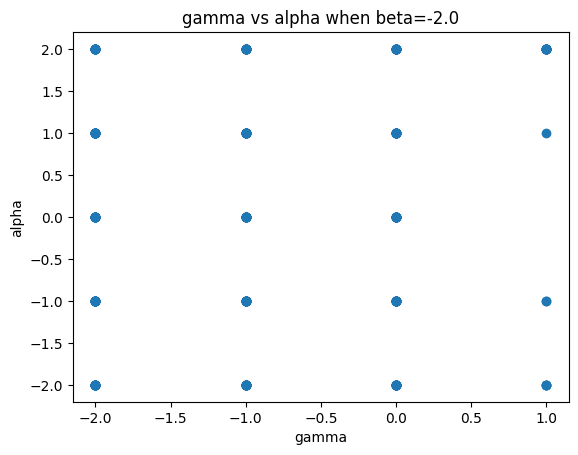

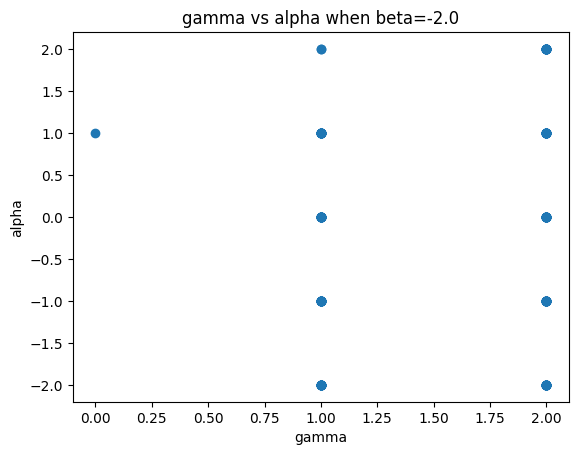

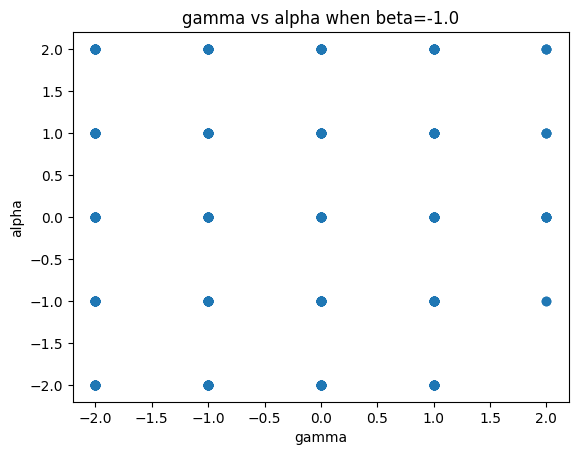

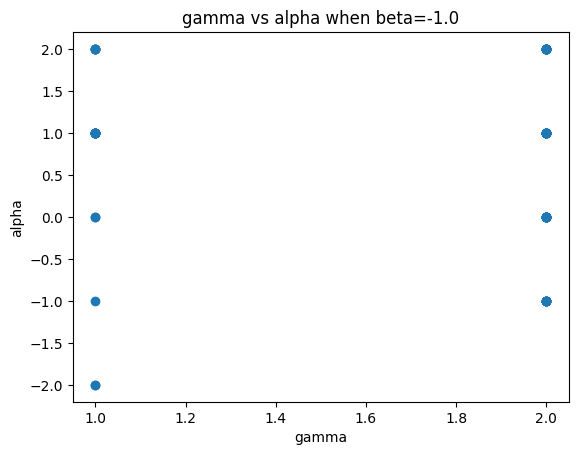

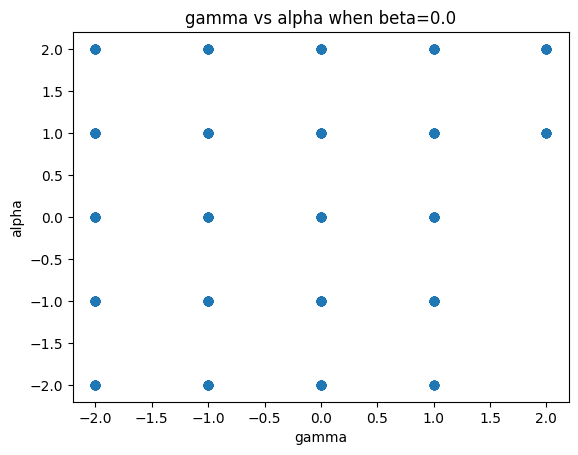

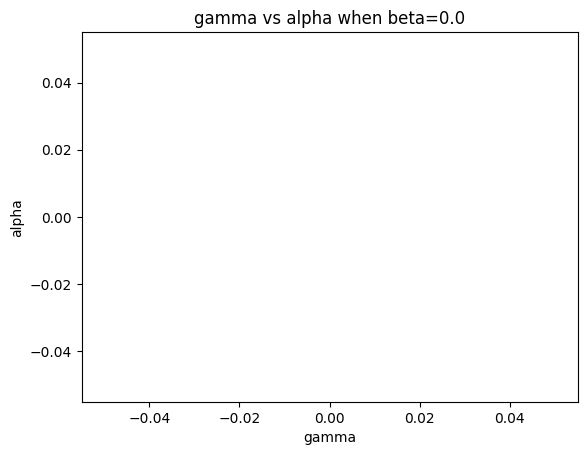

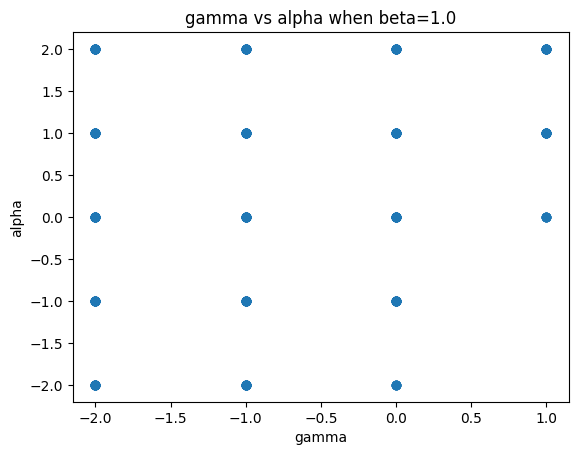

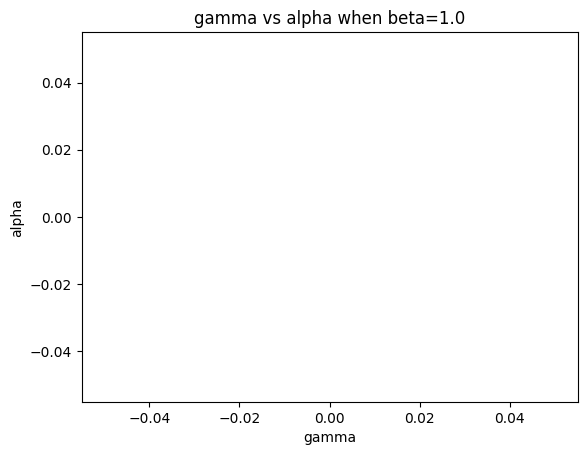

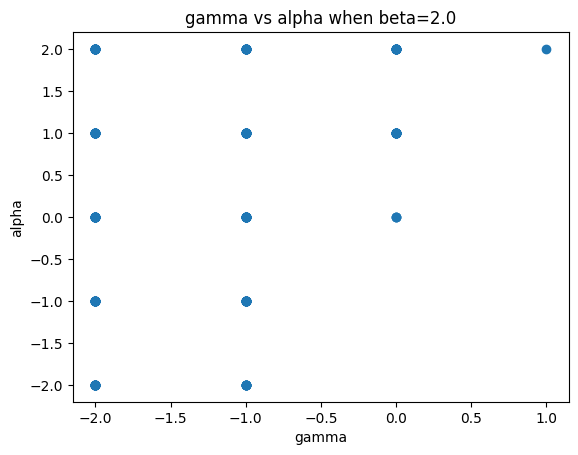

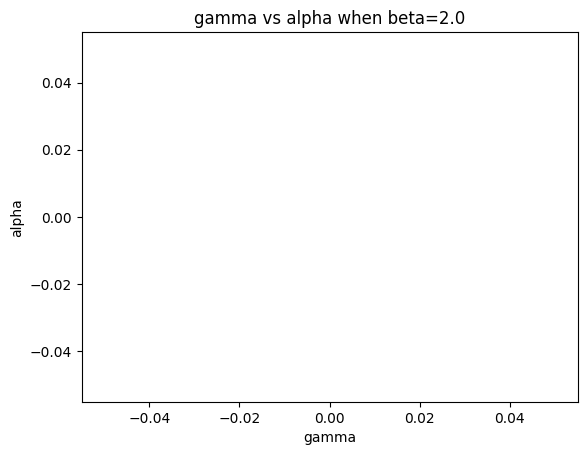

In [64]:
import matplotlib.pyplot as plt

# Data

for beta in np.linspace(-2, 2, 5):
    x = results.loc[results['beta']==beta,'gamma']
    y = results.loc[results['beta']==beta,'alpha']

    # Create plot
    plt.scatter(x, y)

    # Add titles and labels
    plt.title(f"gamma vs alpha when beta={beta}")
    plt.xlabel("gamma")
    plt.ylabel("alpha")

    # Display plot
    plt.show()

    x = results_r2_minus.loc[results_r2_minus['beta']==beta,'gamma']
    y = results_r2_minus.loc[results_r2_minus['beta']==beta,'alpha']

    # Create plot
    plt.scatter(x, y)

    # Add titles and labels
    plt.title(f"gamma vs alpha when beta={beta}")
    plt.xlabel("gamma")
    plt.ylabel("alpha")

    # Display plot
    plt.show()
    
    



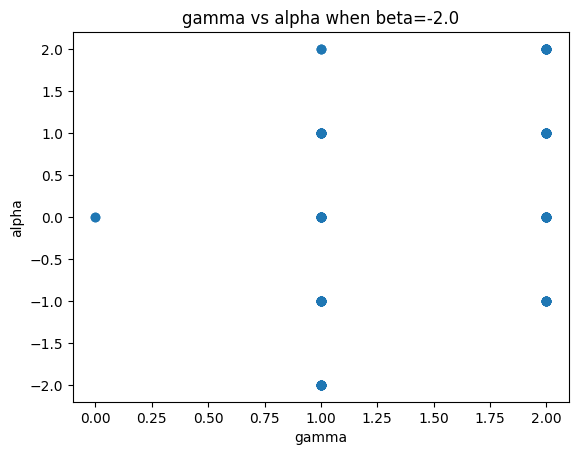

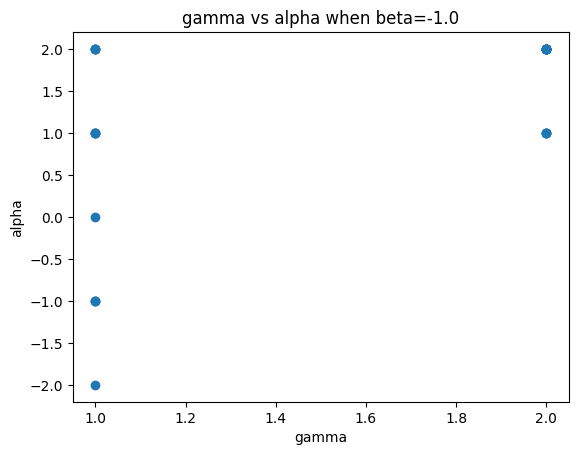

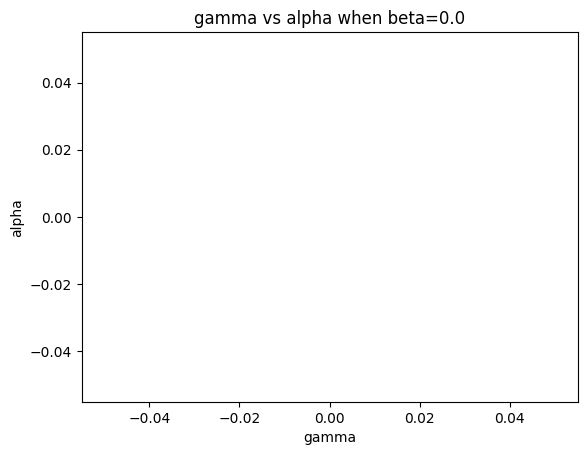

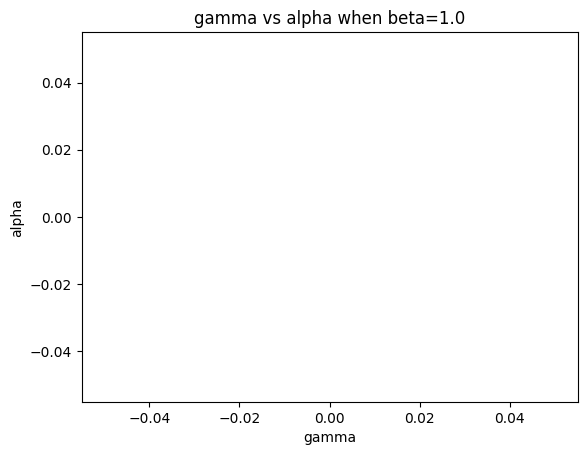

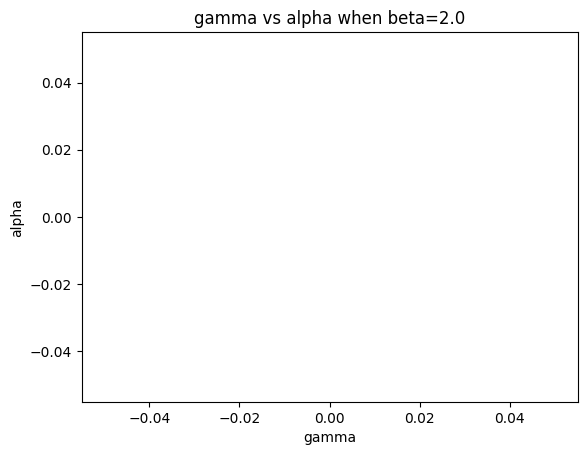

In [ ]:
import matplotlib.pyplot as plt

# Data

for beta in np.linspace(-2, 2, 5):
    x = results_r2_minus.loc[results_r2_minus['beta']==beta,'gamma']
    y = results_r2_minus.loc[results_r2_minus['beta']==beta,'alpha']

    # Create plot
    plt.scatter(x, y)

    # Add titles and labels
    plt.title(f"gamma vs alpha when beta={beta}")
    plt.xlabel("gamma")
    plt.ylabel("alpha")

    # Display plot
    plt.show()
